In [4]:
# !pip install pillow

In [5]:
import os
import pathlib
import yaml
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import pytorch_lightning as pl

from fastmri.data.subsample import create_mask_for_mask_type
from fastmri.data.transforms import UnetDataTransform
from fastmri.data import SliceDataset
from fastmri.pl_modules import UnetModule

from pytorch_lightning.callbacks import ModelCheckpoint


def load_config(config_path="/home/hice1/ltupac3/scratch/configs/unet.yaml"):
    with open(config_path, "r") as f:
        return yaml.safe_load(f)


In [37]:
# Load config
config = load_config()

# Set device and paths
data_path = pathlib.Path(config["data_path"])
print("Data path:", data_path)

# New add!!!!!!!!!!!!!!!
# Checkpoint loading logic
# checkpoint_dir = pathlib.Path("unet_checkpoints/checkpoints")
checkpoint_dir = pathlib.Path(f'{config["default_root_dir"]}/checkpoints')
checkpoint_path = None
if checkpoint_dir.exists():
    ckpt_files = sorted(
        checkpoint_dir.glob("*.ckpt"),
        key=os.path.getmtime
    )
    if ckpt_files:
        checkpoint_path = str(ckpt_files[-1])
        print(f"Resuming from checkpoint: {checkpoint_path}")

# New add!!!!!!!!!!!!!!!
# Define checkpoint callback
checkpoint_callback = ModelCheckpoint(
    dirpath=checkpoint_dir,
    filename="epoch{epoch}-step{step}",
    save_top_k=1,
    monitor="train_loss",
    mode="min",
    save_last=True,
)



# Masking
mask = create_mask_for_mask_type(
    mask_type_str=config["mask_type"],
    center_fractions=config["center_fractions"],
    accelerations=config["accelerations"],
)

transform = UnetDataTransform(
    which_challenge=config["challenge"],
    mask_func=mask,
    use_seed=True,
)

# Dataset and Dataloader
dataset = SliceDataset(
    root=data_path,
    transform=transform,
    challenge=config["challenge"],
)

dataloader = DataLoader(
    dataset,
    batch_size=config["batch_size"],
    num_workers=config["num_workers"],
    shuffle=True,
)

# Model
model = UnetModule.load_from_checkpoint(
    checkpoint_path="/home/hice1/ltupac3/scratch/unet_checkpoints/checkpoints/epoch=2-step=52112.ckpt",
    in_chans=config["in_chans"],
    out_chans=config["out_chans"],
    chans=config["chans"],
    num_pool_layers=config["num_pool_layers"],
    drop_prob=config["drop_prob"],
    lr=config["lr"],
    lr_step_size=config["lr_step_size"],
    lr_gamma=config["lr_gamma"],
    weight_decay=config["weight_decay"],
)


Data path: /home/hice1/ltupac3/scratch/fastMRI_data/singlecoil_train


In [38]:
# grab image and target from unet object
sample = next(iter(dataloader))

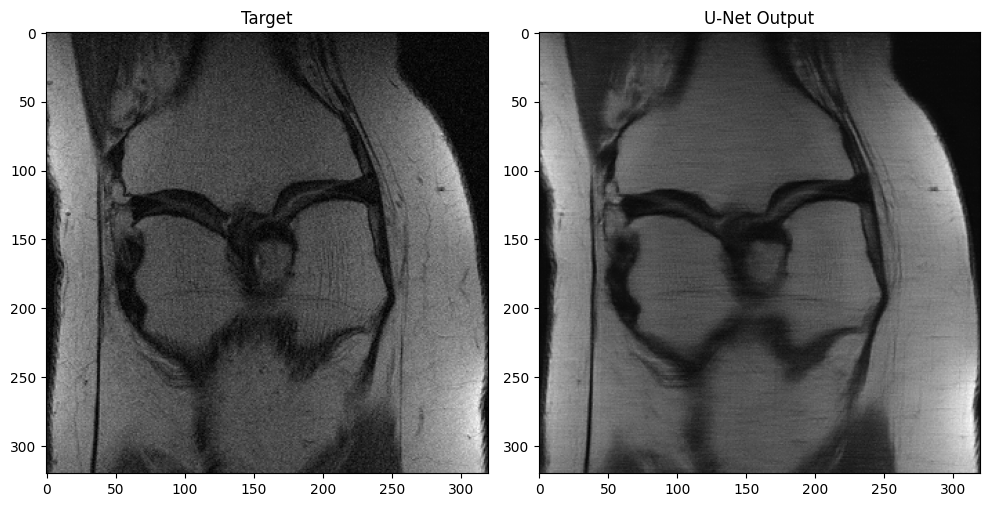

In [39]:
image = sample.image
target = sample.target

# image.shape

with torch.no_grad():
    output = model(image)  

# output.shape


fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(target[0].numpy(), cmap="gray")
axes[0].set_title("Target")
axes[1].imshow(output.detach().squeeze().numpy(), cmap="gray")
axes[1].set_title("U-Net Output")
plt.tight_layout()
plt.show()


In [40]:
# okay here we're blocking off the center of image. 
# we need to find the ROI
def create_roi_mask(image_shape, roi_size=(128, 128)):
    h, w = image_shape[-2:]  # (H, W)
    rh, rw = roi_size
    mask = torch.zeros((h, w), dtype=torch.bool)
    start_h = h // 2 - rh // 2
    start_w = w // 2 - rw // 2
    mask[start_h:start_h + rh, start_w:start_w + rw] = 1
    return mask


In [46]:
# target and output are both shape [1, 320, 320]
target_img = target[0]
output_img = output[0]

roi_mask = create_roi_mask(target_img.shape, roi_size=(160, 160))
target_roi = target_img[roi_mask]
output_roi = output_img[roi_mask]

# quick MSE in ROI
mse_roi = torch.mean((target_roi - output_roi) ** 2).item()
print(f"ROI MSE: {mse_roi:.4f}")


ROI MSE: 0.0517


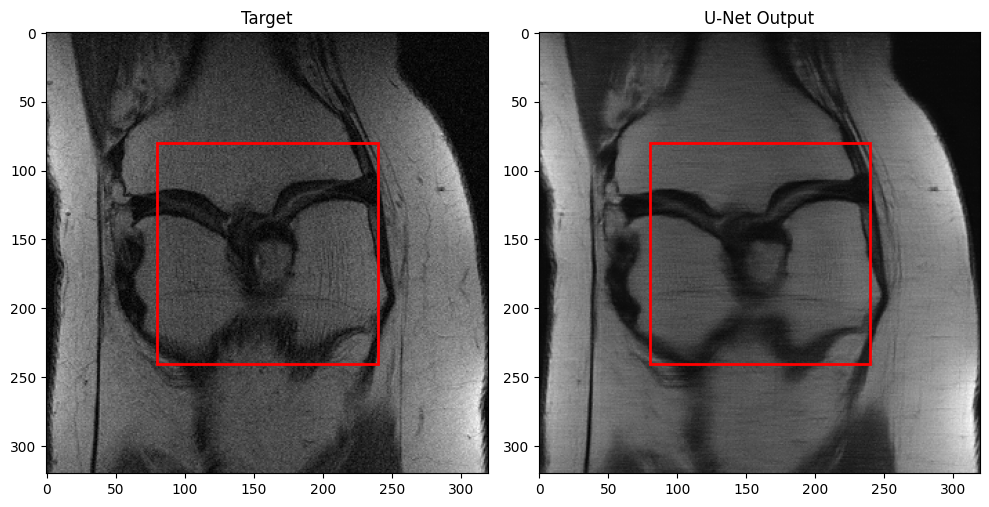

In [45]:
import matplotlib.patches as patches

def draw_roi_box(ax, roi_size=(160, 160), image_shape=(320, 320)):
    rh, rw = roi_size
    h, w = image_shape
    start_h = h // 2 - rh // 2
    start_w = w // 2 - rw // 2
    rect = patches.Rectangle((start_w, start_h), rw, rh, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

# plot with ROI overlay
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(target_img.cpu(), cmap='gray')
axes[0].set_title("Target")
draw_roi_box(axes[0])

axes[1].imshow(output_img.cpu(), cmap='gray')
axes[1].set_title("U-Net Output")
draw_roi_box(axes[1])

plt.tight_layout()
plt.show()


# ROI weighted mse loss

In [43]:
def create_roi_mask_tensor(image_tensor, roi_size=(128, 128)):
    # image_tensor: [B, H, W]
    B, H, W = image_tensor.shape
    rh, rw = roi_size
    mask = torch.zeros((B, H, W), device=image_tensor.device)
    start_h = H // 2 - rh // 2
    start_w = W // 2 - rw // 2
    mask[:, start_h:start_h+rh, start_w:start_w+rw] = 1
    return mask


In [ ]:
def roi_weighted_mse(pred, target, alpha=2.0, roi_size=(128, 128)):
    roi_mask = create_roi_mask_tensor(target, roi_size)
    loss = (pred - target) ** 2
    weighted_loss = (1 + (alpha - 1) * roi_mask) * loss
    return weighted_loss.mean()


# would need to modify the model to use this loss funciton and care more about ROI